In [1]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(SingleCellExperiment)
library(scater)
library(mclust)
library(kableExtra)
library(cowplot)
library(tidyverse)
library(reshape)
library(harmony)
library(SingleR)
library(topGO)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(ReactomePA)
library(seq2pathway)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(clusterProfiler)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 20),
    axis.title = element_text(size = 20),
    text = element_text(size = 20, colour = "black"),
    legend.text = element_text(size = 20),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: ‘DT’


The following object is masked from ‘package:SeuratObject’:

    JS


The following object is masked from ‘package:Seurat’:

    JS



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


here() starts at /home/vercanie/PRIMUS/data/48_lab/Jupyter/231003_DiabetesV02

Loading required package: SummarizedExperiment

Loading requir

Warning message:
“replacing previous import ‘WGCNA::cor’ by ‘stats::cor’ when loading ‘seq2pathway’”
scCustomize v1.1.1
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:reshape’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:IRanges’:

    sli

# All diabetes data - new and old

## CD4 new

In [2]:
paths  <- list.files("data/rawdata/", full.names = T)

In [3]:
paths

[1] "data/rawdata//exp08_init_with_Mixcr.rds"      
 [2] "data/rawdata//exp10_init_with_Mixcr.rds"      
 [3] "data/rawdata//exp11_W1_init_with_Mixcr.rds"   
 [4] "data/rawdata//exp11_W2_init_with_Mixcr.rds"   
 [5] "data/rawdata//exp16_CD4_A_init_with_Mixcr.rds"
 [6] "data/rawdata//exp16_CD4_B_init_with_Mixcr.rds"
 [7] "data/rawdata//exp16_CD8_A_init_with_Mixcr.rds"
 [8] "data/rawdata//exp16_CD8_B_init_with_Mixcr.rds"
 [9] "data/rawdata//exp18_1_init_with_Mixcr.rds"    
[10] "data/rawdata//exp18_2_init_with_Mixcr.rds"    
[11] "data/rawdata//exp18_3_init_with_Mixcr.rds"    
[12] "data/rawdata//exp18_4_init_with_Mixcr.rds"    
[13] "data/rawdata//exp19_1_init_with_Mixcr.rds"    
[14] "data/rawdata//exp19_2_init_with_Mixcr.rds"    
[15] "data/rawdata//exp19_3_init_with_Mixcr.rds"    
[16] "data/rawdata//exp19_4_init_with_Mixcr.rds"    
[17] "data/rawdata//exp20_1_init_with_Mixcr.rds"    
[18] "data/rawdata//exp20_2_init_with_Mixcr.rds"    
[19] "data/rawdata//exp20_3_init_with_Mixcr.rds"    
[20] "data/rawdata//exp20_4_init_with_Mixcr.rds"

In [4]:
seu_list  <- map(paths[c(2,4,5,6,10,12,14,16,18,20)], readRDS)

In [5]:
seu_list[[1]]$hashtags  %>% table

.
 H1 H10  H2  H3  H4  H5  H6  H7  H8  H9 
743 831 821 762 825 695 821 761 787 802 

In [6]:
exp10_cd4  <- subset(seu_list[[1]], hashtags != "H5")

In [7]:
seu_list[[1]] <- exp10_cd4

In [8]:
seu_list[[1]]$Condition  %>% table

.
Ctrl T0  Dia T0 
   2326    4827 

In [9]:
new_dia_cd4  <- scCustomize::Merge_Seurat_List(seu_list)

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [90]:
new_dia_cd4

An object of class Seurat 
15427 features across 98852 samples within 3 assays 
Active assay: RNA (15413 features, 0 variable features)
 2 other assays present: Antibodies, PTPRC

In [10]:
options(future.globals.maxSize = 10000 * 1024^2)
plan("sequential")

In [11]:
DefaultAssay(new_dia_cd4)  <- "RNA"
new_dia_cd4 <- NormalizeData(new_dia_cd4, verbose = FALSE)
new_dia_cd4 <- ScaleData(new_dia_cd4, verbose = FALSE)
new_dia_cd4 <- FindVariableFeatures(new_dia_cd4, nfeatures = 1000, verbose = FALSE)
new_dia_cd4 <- RunPCA(new_dia_cd4, npcs = 12, verbose = FALSE)
new_dia_cd4 <- RunUMAP(new_dia_cd4, reduction = "pca", dims = 1:12)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:59:03 UMAP embedding parameters a = 0.9922 b = 1.112

20:59:03 Read 98852 rows and found 12 numeric columns

20:59:03 Using Annoy for neighbor search, n_neighbors = 30

20:59:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:59:17 Writing NN index file to temp file /tmp/RtmpfNiPa0/file3fb63159f953c0

20:59:17 Searching Annoy index using 1 thread, search_k = 3000

21:00:07 Annoy recall = 100%

21:00:09 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

In [12]:
new_dia_cd4 <- FindNeighbors(new_dia_cd4, dims = 1:12)
new_dia_cd4 <- FindClusters(new_dia_cd4, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 98852
Number of edges: 2594592

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8275
Number of communities: 20
Elapsed time: 64 seconds


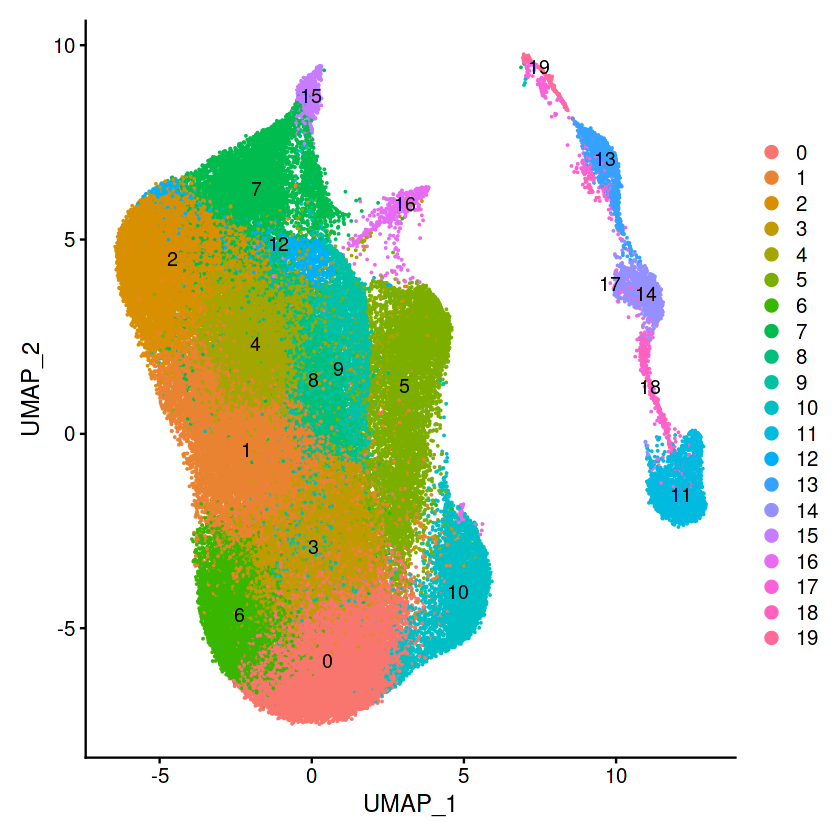

In [13]:
DimPlot(new_dia_cd4, label = T)

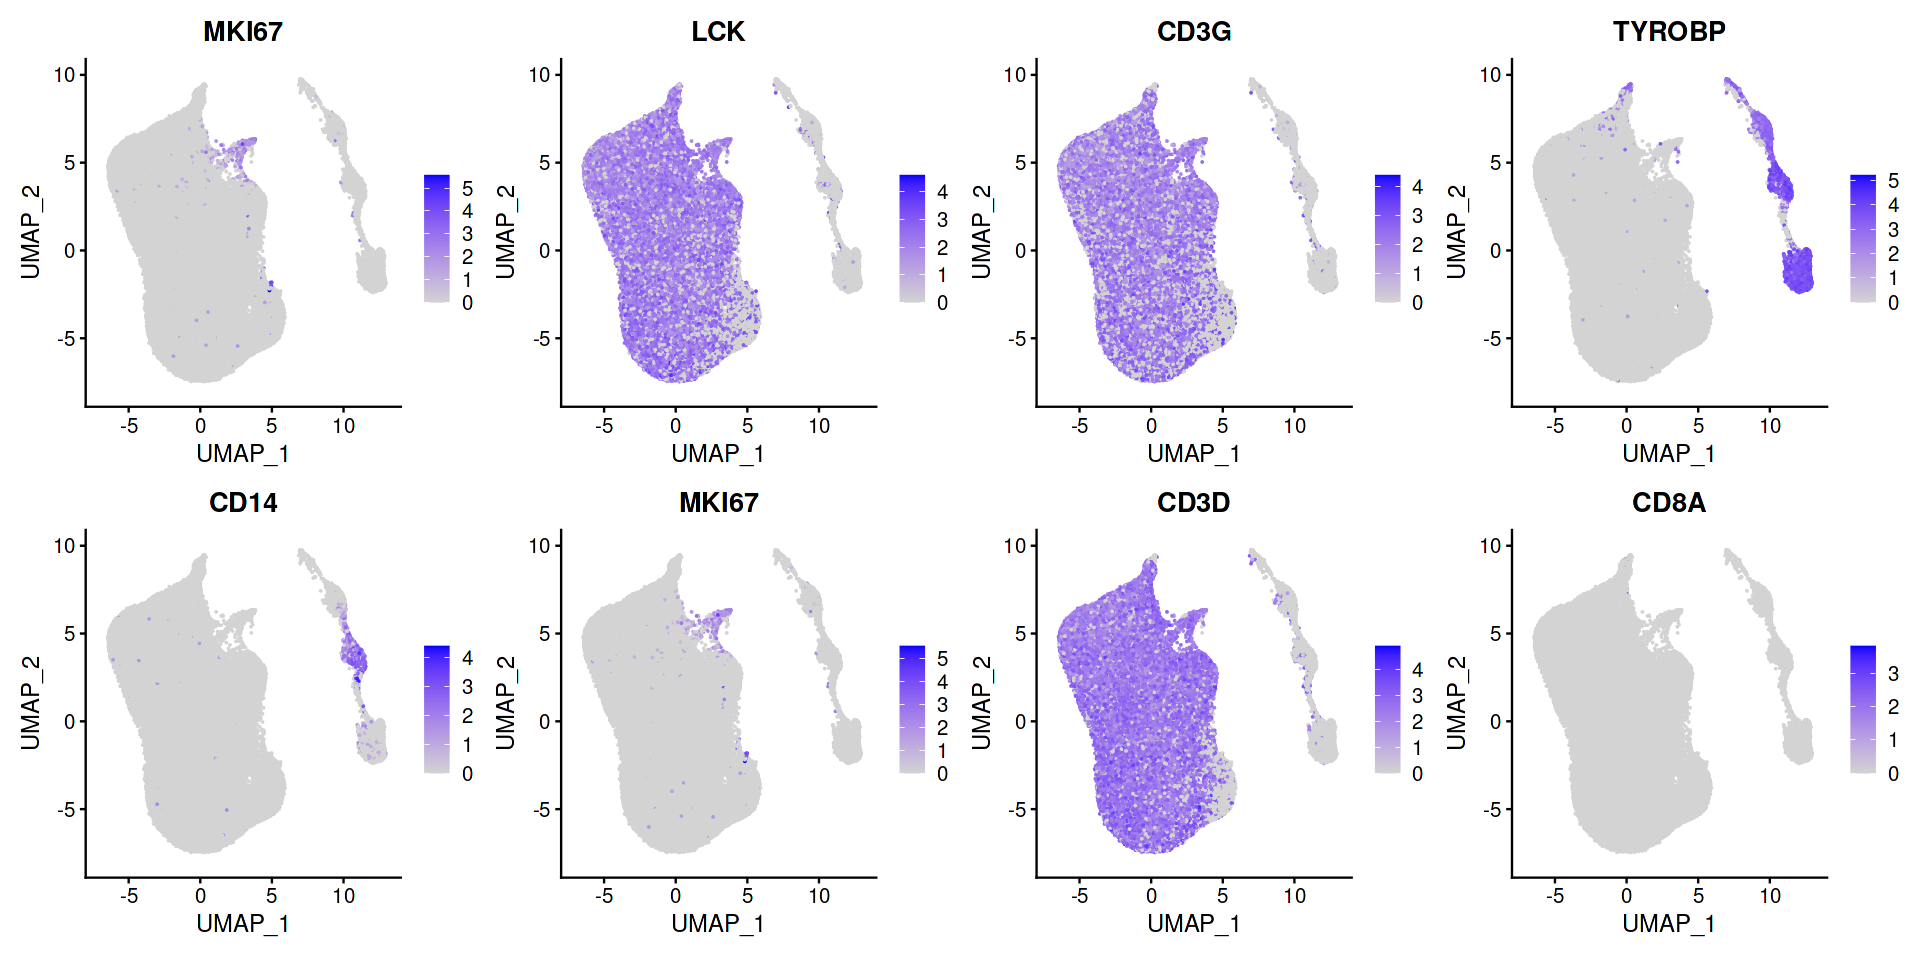

In [14]:
options(repr.plot.width = 16, repr.plot.height = 8)
FeaturePlot(new_dia_cd4, features = c("MKI67", "LCK", "CD3G", "TYROBP", "CD14", "MKI67", "CD3D", "CD8A"), ncol = 4)

### Remove contaminating cells

In [15]:
new_dia_cd4  <- subset(new_dia_cd4, seurat_clusters %in% c(0:10,12,15,16))

In [17]:
DefaultAssay(new_dia_cd4)  <- "RNA"
new_dia_cd4 <- NormalizeData(new_dia_cd4, verbose = FALSE)

new_dia_cd4 <- ScaleData(new_dia_cd4, verbose = FALSE)
new_dia_cd4 <- FindVariableFeatures(new_dia_cd4, nfeatures = 1000, verbose = FALSE)
new_dia_cd4 <- RunPCA(new_dia_cd4, npcs = 12, verbose = FALSE)
new_dia_cd4 <- RunUMAP(new_dia_cd4, reduction = "pca", dims = 1:12)

new_dia_cd4 <- FindNeighbors(new_dia_cd4, dims = 1:12)
new_dia_cd4 <- FindClusters(new_dia_cd4, resolution = 1)

21:12:10 UMAP embedding parameters a = 0.9922 b = 1.112

21:12:10 Read 92900 rows and found 12 numeric columns

21:12:10 Using Annoy for neighbor search, n_neighbors = 30

21:12:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:12:27 Writing NN index file to temp file /tmp/RtmpfNiPa0/file3fb63164f8fa82

21:12:27 Searching Annoy index using 1 thread, search_k = 3000

21:13:18 Annoy recall = 100%

21:13:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:13:27 Initializing from normalized Laplacian + noise (using irlba)

21:13:36 Commencing optimization for 200 epochs, with 3935436 positive edges

21:14:49 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 92900
Number of edges: 2327949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8133
Number of communities: 17
Elapsed time: 62 seconds


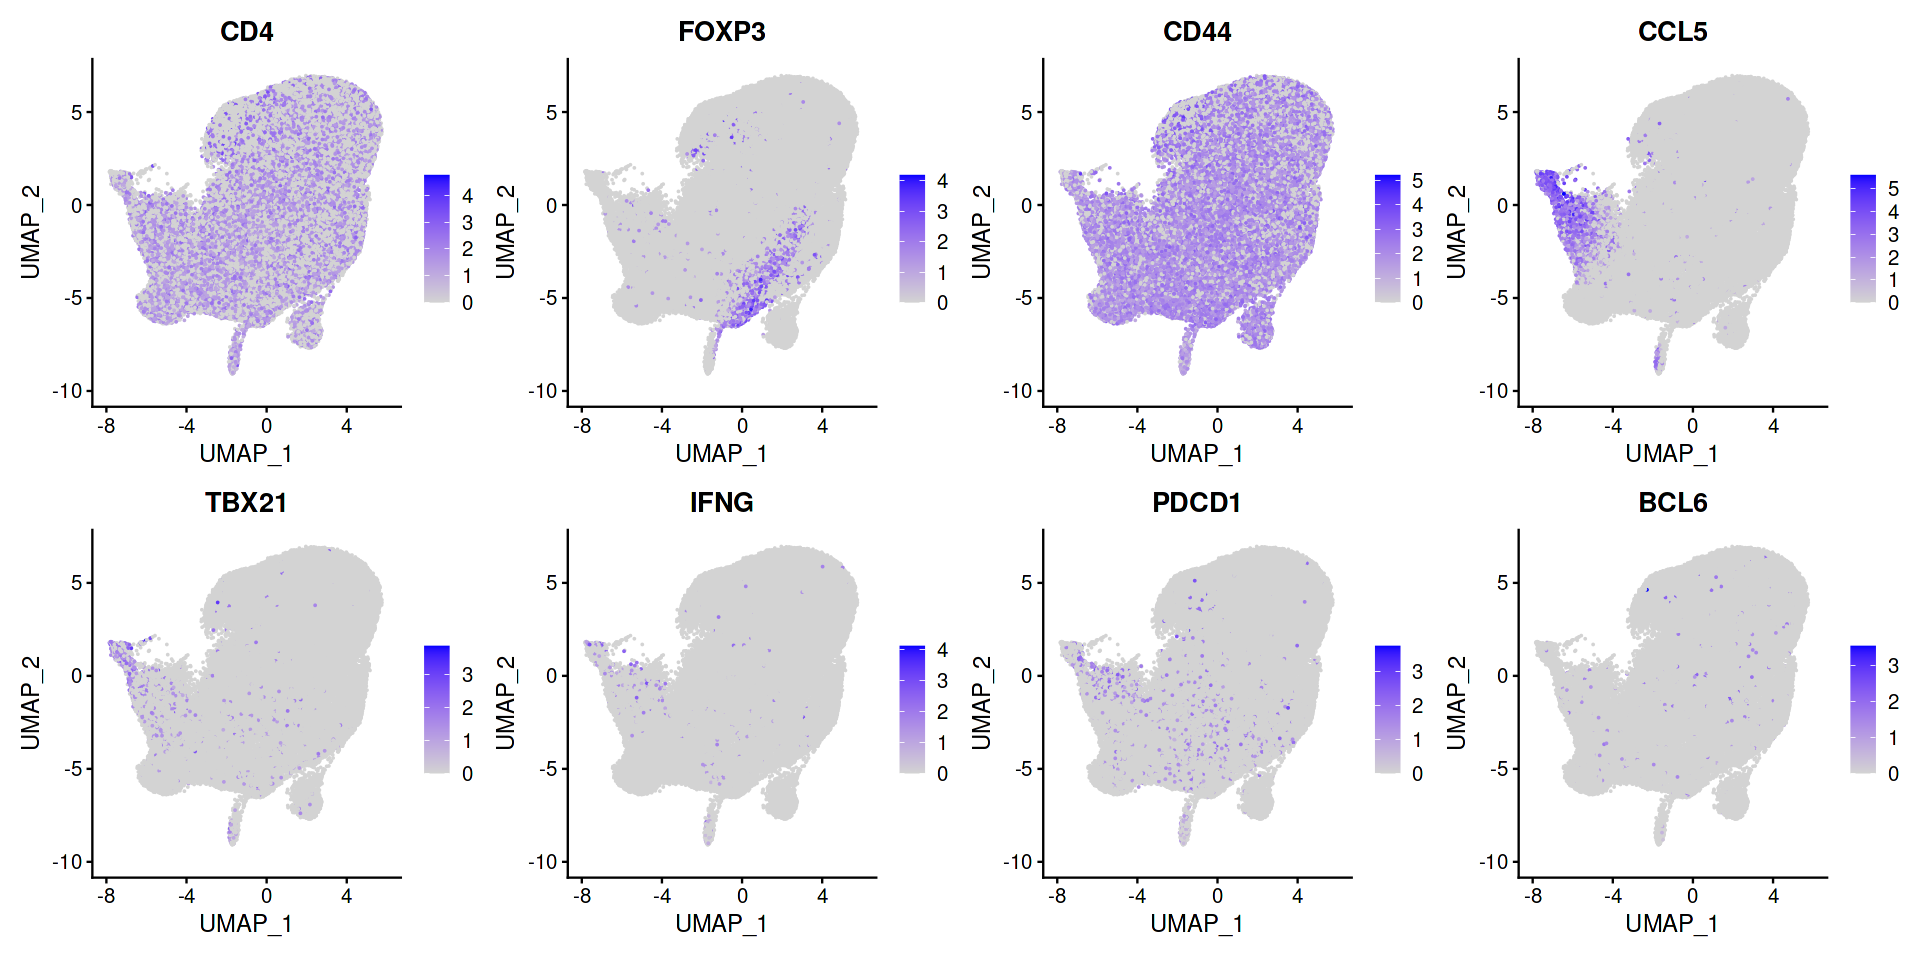

In [18]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd4, features = c("CD4", "FOXP3", "CD44", "CCL5", "TBX21", "IFNG", "PDCD1", "BCL6"), ncol = 4)

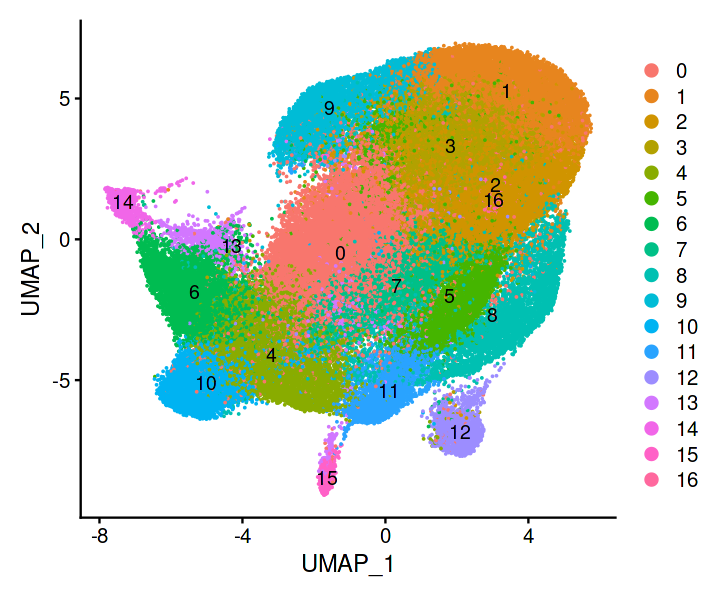

In [19]:
options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(new_dia_cd4, label = T)

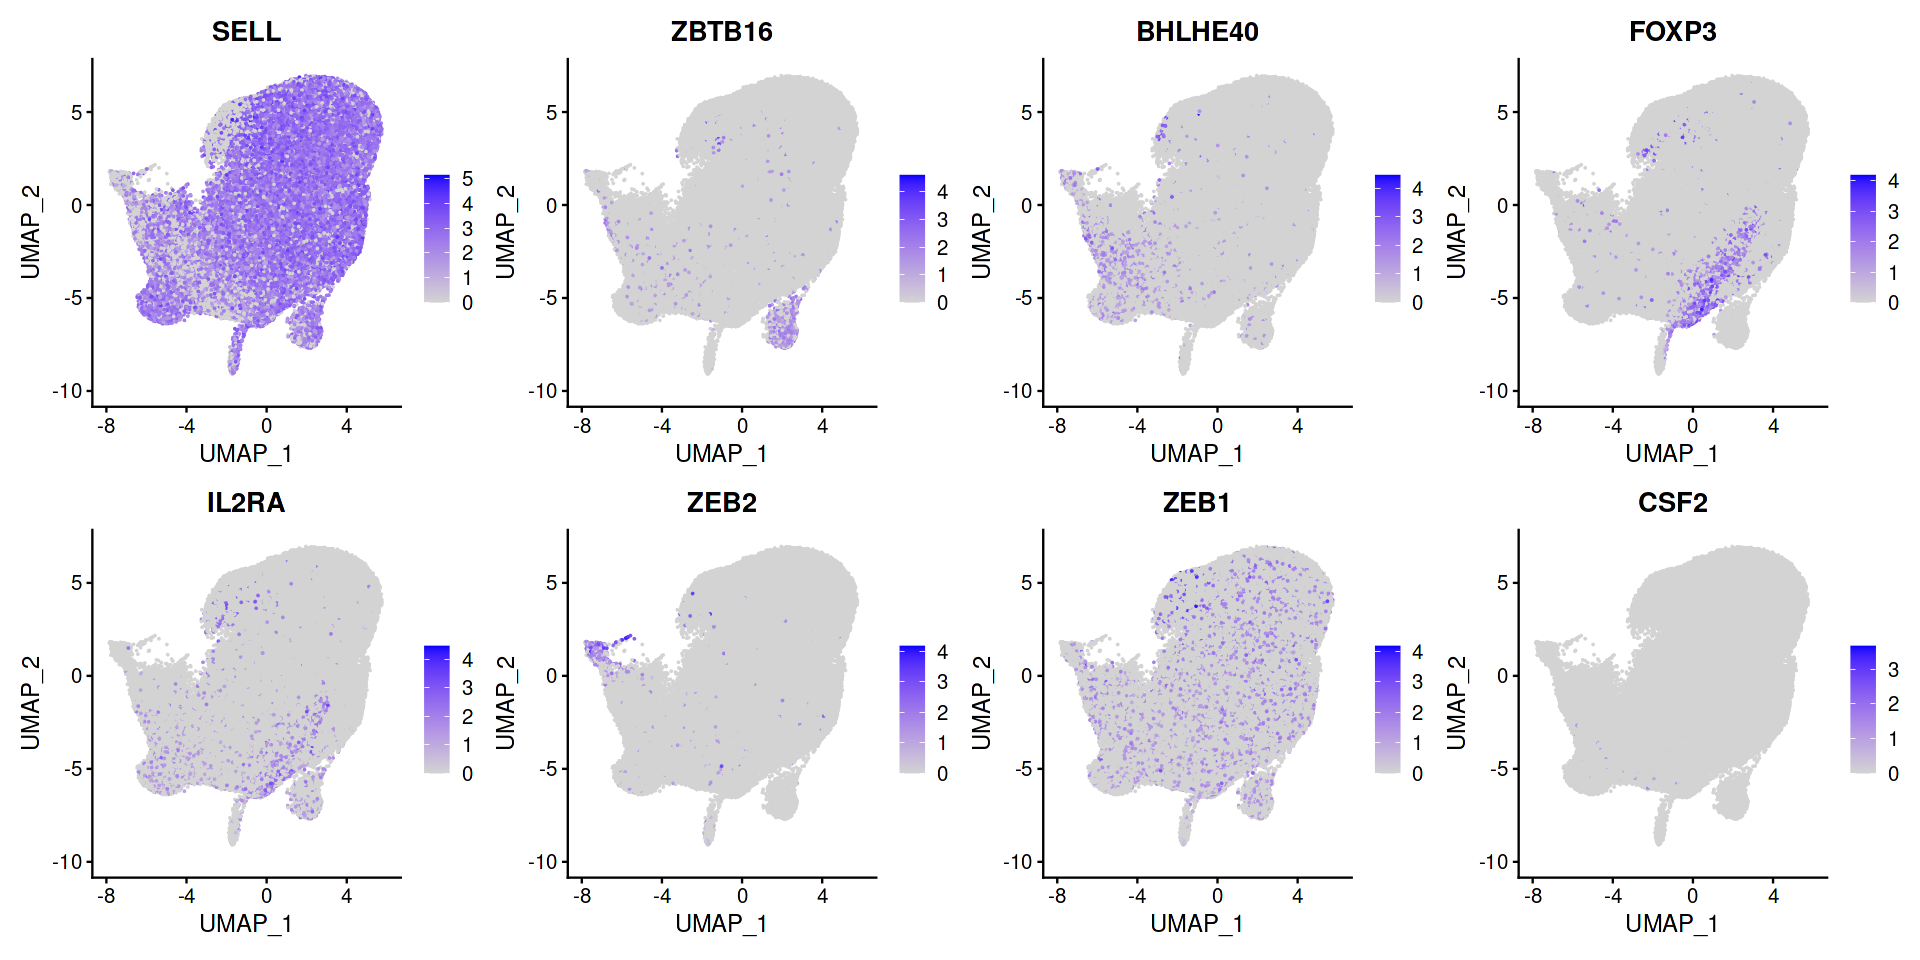

In [20]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd4, features = c("SELL", "ZBTB16", "BHLHE40", "FOXP3", "IL2RA", "ZEB2", "ZEB1", "CSF2"), ncol = 4)

In [21]:
new_dia_cd4@meta.data  <- new_dia_cd4@meta.data  %>% separate(Condition, into = c("Disease", "Time"), remove = F, sep = " ")

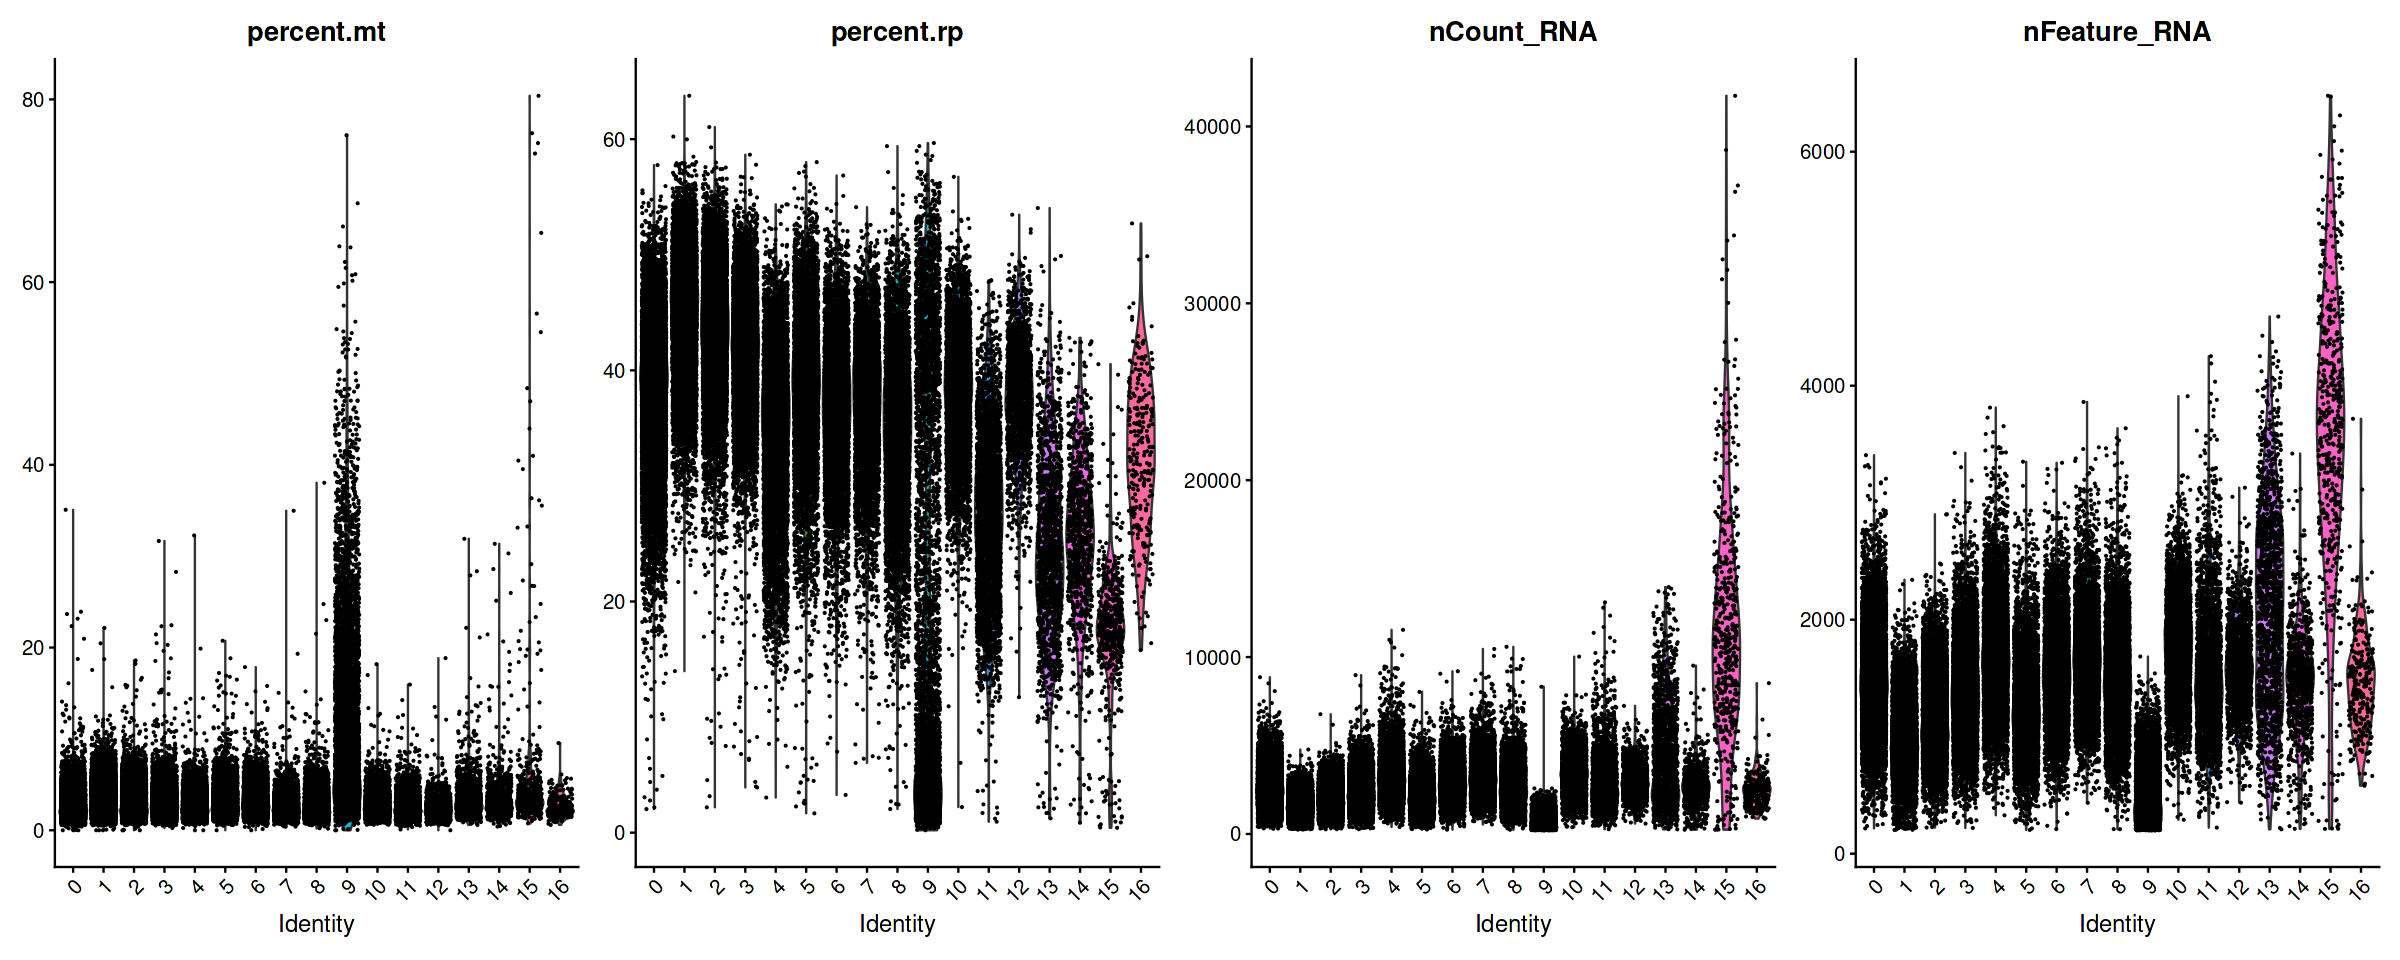

In [22]:
options(repr.plot.width = 20)
VlnPlot(new_dia_cd4, features = c("percent.mt", "percent.rp", "nCount_RNA", "nFeature_RNA"), ncol = 4)

### Remove dead cells

In [23]:
cutoff_nFeature_RNA <- 500
cutoff_percent_mt <- 10
cluster_exclude <- c(9)

In [ ]:
annotate_tcell_data  <- function(seurat_dataset){
    
    ## This function annotates a Seurat object with three annotations:
    ## 1. Monaco Immune dataset annotations
    ## 2. Annotations based on bulk RNAseq from Giles et al, 2022
    ## 3. Azimuth annotations
        
    DefaultAssay(seurat_dataset)  <- "RNA"
	
    ### Annotate the dataset with Monaco Immune dataset
		pred.singler <- SingleR(test = seurat_dataset@assays$RNA@counts, ref = mid.se, assay.type.test=1,
		labels = mid.se$label.fine)
    
	### Annotate the dataset with Wherry dataset
        pred.singler2 <- SingleR(test = seurat_dataset@assays$RNA@counts, ref = ref_wherry_new$matrix,
		labels = ref_wherry_new$labels)

		all_labels <- data.frame(
		Monaco_single = pred.singler$labels,
		Wherry_main = pred.singler2$labels,
		barcode = colnames(seurat_dataset))
		
		md2 <- seurat_dataset@meta.data
		md2$barcode = colnames(seurat_dataset)

		md3 <- left_join(md2, all_labels)

		seurat_dataset@meta.data <- md3
		rownames(seurat_dataset@meta.data) <- colnames(seurat_dataset)
		
	### Annotate the dataset with Azimuth
		
		seurat_dataset <- RunAzimuth(seurat_dataset, reference = "pbmcref")
		seurat_dataset$predicted.celltype.l1 %>% table
		seurat_dataset$predicted.celltype.l2 %>% table
		seurat_dataset$predicted.celltype.l3 %>% table
		table(seurat_dataset$predicted.celltype.l3, seurat_dataset$Wherry_main)
		table(seurat_dataset$predicted.celltype.l3, seurat_dataset$Monaco_single)
		table(seurat_dataset$Wherry_main, seurat_dataset$Monaco_single)
		return(seurat_dataset)
	}


new_dia_cd4  <- annotate_tcell_data(new_dia_cd4)

In [24]:
p1 <- ggplot(data.frame(nCount_RNA = new_dia_cd4$nCount_RNA,
                  nFeature_RNA = new_dia_cd4$nFeature_RNA,
                  percent_mt = new_dia_cd4$percent.mt,
                  seurat_clusters = new_dia_cd4$seurat_clusters,
                  exclude = ifelse(new_dia_cd4$seurat_clusters %in% cluster_exclude, TRUE, FALSE)), 
       aes(x = seurat_clusters, y = percent_mt)) +
  geom_violin(scale = "width", aes(fill = exclude)) + 
  geom_hline(yintercept = cutoff_percent_mt,
               geom = "line", 
               width = 0.5,
               colour = "red") + 
  ggtitle("Percent mt. cutoff") + 
  theme_classic() +
  scale_fill_manual(values = c("white","red")) +
  theme(panel.background = element_blank(), 
        axis.text.x = element_text(angle = 0, hjust = 1)) +
  annotate(geom = "rect", xmin = min(as.numeric(new_dia_cd4$seurat_clusters))-1, 
           xmax = max(as.numeric(new_dia_cd4$seurat_clusters))+1, 
           ymin=cutoff_percent_mt,ymax=1.1*(max(new_dia_cd4$percent.mt)), fill = "red", alpha = 0.1)

p2 <- ggplot(data.frame(nCount_RNA = new_dia_cd4$nCount_RNA,
                  nFeature_RNA = new_dia_cd4$nFeature_RNA,
                  percent_mt = new_dia_cd4$percent.mt,
                  seurat_clusters = new_dia_cd4$seurat_clusters,
                        exclude = ifelse(new_dia_cd4$seurat_clusters %in% cluster_exclude, TRUE, FALSE)), 
       aes(x = seurat_clusters, y = nFeature_RNA)) +
  geom_violin(scale = "width", aes(fill = exclude)) + 
  geom_hline(yintercept = cutoff_nFeature_RNA,
               geom = "line", 
               width = 0.5,
               colour = "red") + 
  ggtitle("nFeature RNA cutoff") + 
  theme_classic() +
  scale_fill_manual(values = c("white","red")) +
  theme(panel.background = element_blank(), 
        axis.text.x = element_text(angle = 0, hjust = 1)) +
  annotate(geom = "rect", xmin = min(as.numeric(new_dia_cd4$seurat_clusters))-1, 
           xmax = max(as.numeric(new_dia_cd4$seurat_clusters))+1, 
           ymin=0, ymax=cutoff_nFeature_RNA, fill = "red", alpha = 0.1)

Warning message in geom_hline(yintercept = cutoff_percent_mt, geom = "line", width = 0.5, :
“Ignoring unknown parameters: `geom` and `width`”
Warning message in geom_hline(yintercept = cutoff_nFeature_RNA, geom = "line", width = 0.5, :
“Ignoring unknown parameters: `geom` and `width`”


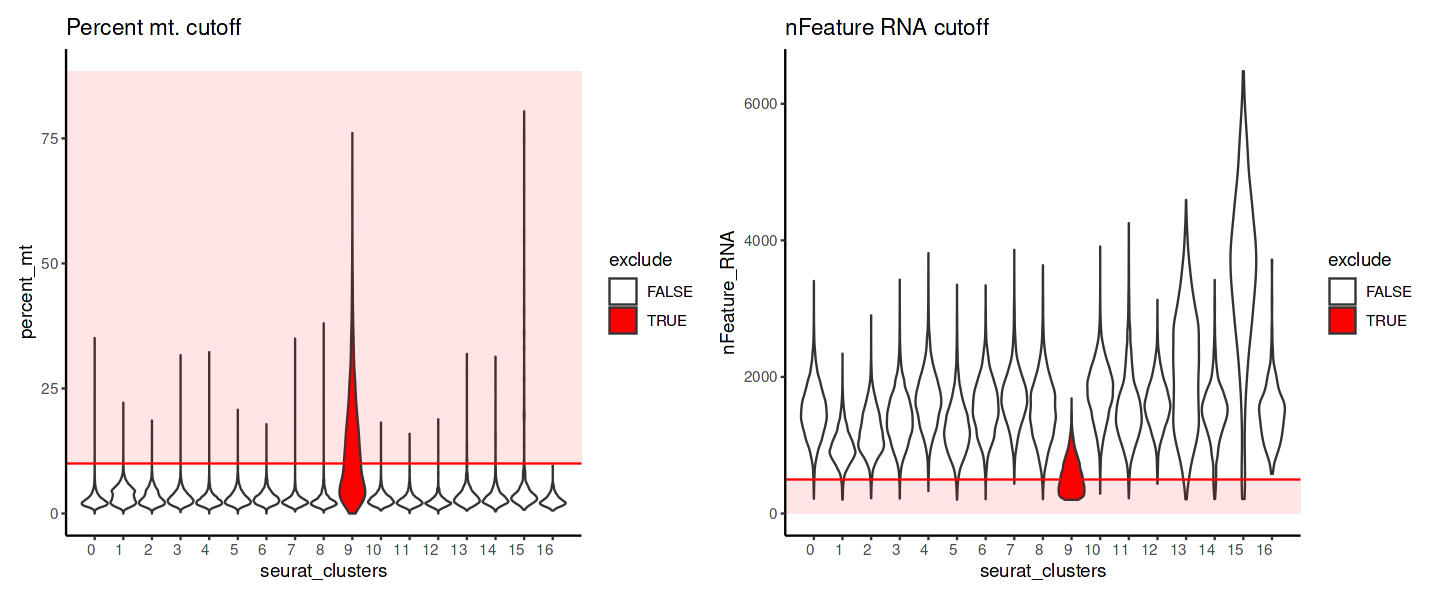

In [25]:
options(repr.plot.width = 12, repr.plot.height = 5)
p1 + p2

In [26]:
new_dia_cd4  <- subset(new_dia_cd4, 
                       seurat_clusters %in% c(0:8,10:16) &
                      percent.mt < cutoff_percent_mt &
                      nFeature_RNA > cutoff_nFeature_RNA)

In [27]:
new_dia_cd4 <- NormalizeData(new_dia_cd4, verbose = FALSE)

new_dia_cd4 <- ScaleData(new_dia_cd4, verbose = FALSE)
new_dia_cd4 <- FindVariableFeatures(new_dia_cd4, nfeatures = 1000, verbose = FALSE)
new_dia_cd4 <- RunPCA(new_dia_cd4, npcs = 12, verbose = FALSE)
new_dia_cd4 <- RunUMAP(new_dia_cd4, reduction = "pca", dims = 1:12)

new_dia_cd4 <- FindNeighbors(new_dia_cd4, dims = 1:12)
new_dia_cd4 <- FindClusters(new_dia_cd4, resolution = 1)

21:19:57 UMAP embedding parameters a = 0.9922 b = 1.112

21:19:57 Read 86848 rows and found 12 numeric columns

21:19:57 Using Annoy for neighbor search, n_neighbors = 30

21:19:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:20:08 Writing NN index file to temp file /tmp/RtmpfNiPa0/file3fb6311238c0eb

21:20:09 Searching Annoy index using 1 thread, search_k = 3000

21:20:57 Annoy recall = 100%

21:20:59 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:21:07 Initializing from normalized Laplacian + noise (using irlba)

21:21:14 Commencing optimization for 200 epochs, with 3633604 positive edges

21:22:19 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86848
Number of edges: 2188307

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8092
Number of communities: 19
Elapsed time: 60 seconds


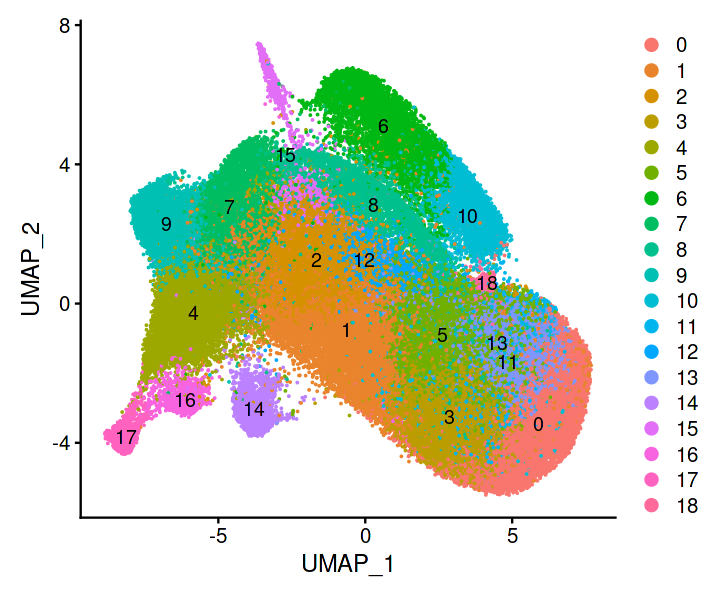

In [28]:
options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(new_dia_cd4, label = T)

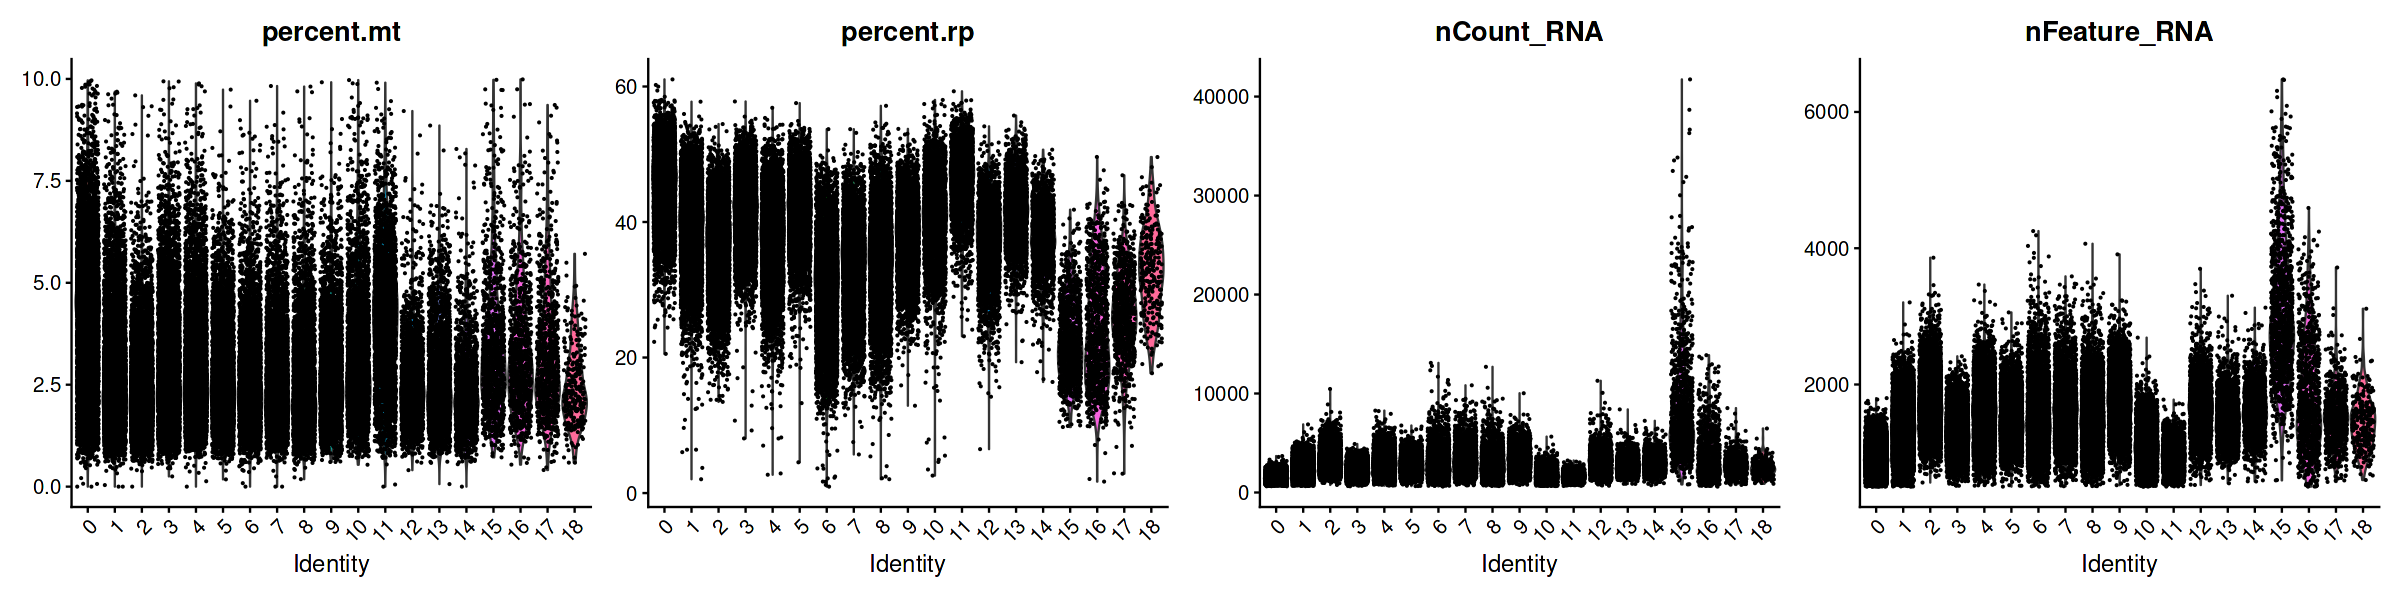

In [29]:
options(repr.plot.width = 20)
VlnPlot(new_dia_cd4, features = c("percent.mt", "percent.rp", "nCount_RNA", "nFeature_RNA"), ncol = 4)

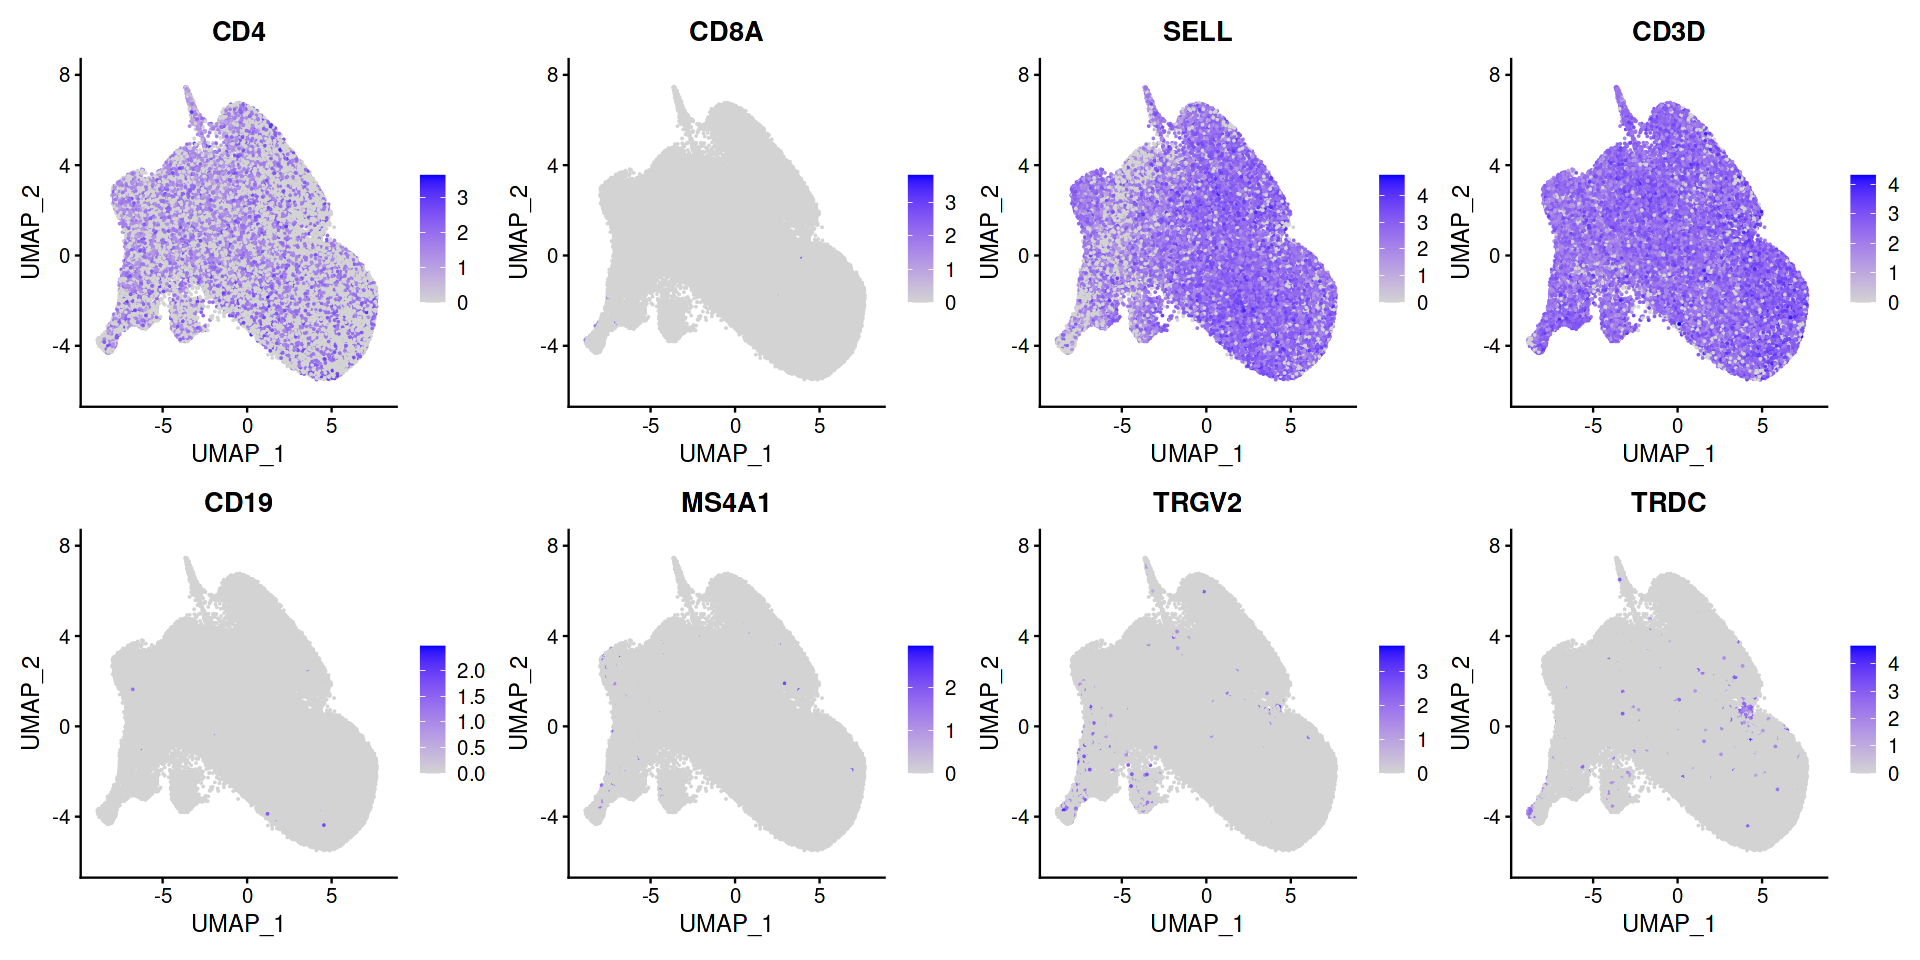

In [30]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd4, features = c("CD4", "CD8A", "SELL", "CD3D", "CD19", "MS4A1", "TRGV2", "TRDC"), ncol = 4)

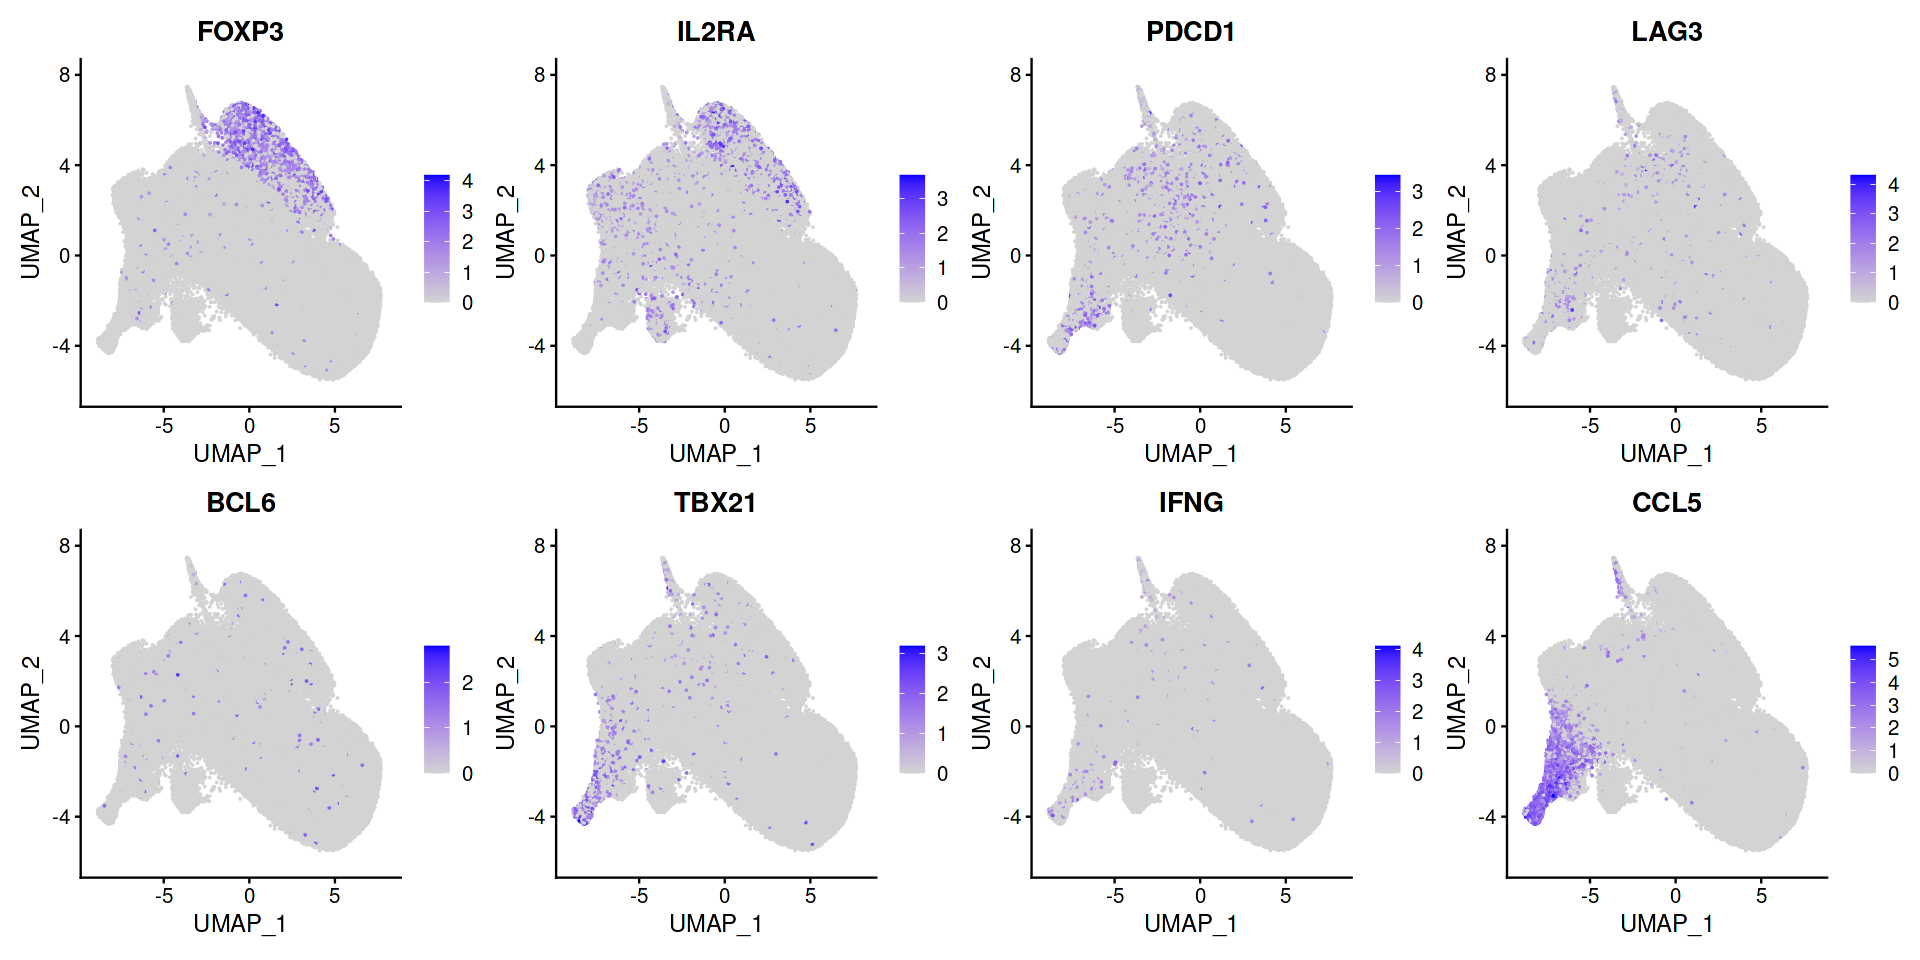

In [31]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd4, features = c("FOXP3", "IL2RA", "PDCD1", "LAG3", "BCL6", "TBX21", "IFNG", "CCL5"), ncol = 4)

Warning message:
“Could not find PTPRC-RA in the default search locations, found in PTPRC assay instead”
Warning message:
“Could not find PTPRC-RO in the default search locations, found in PTPRC assay instead”


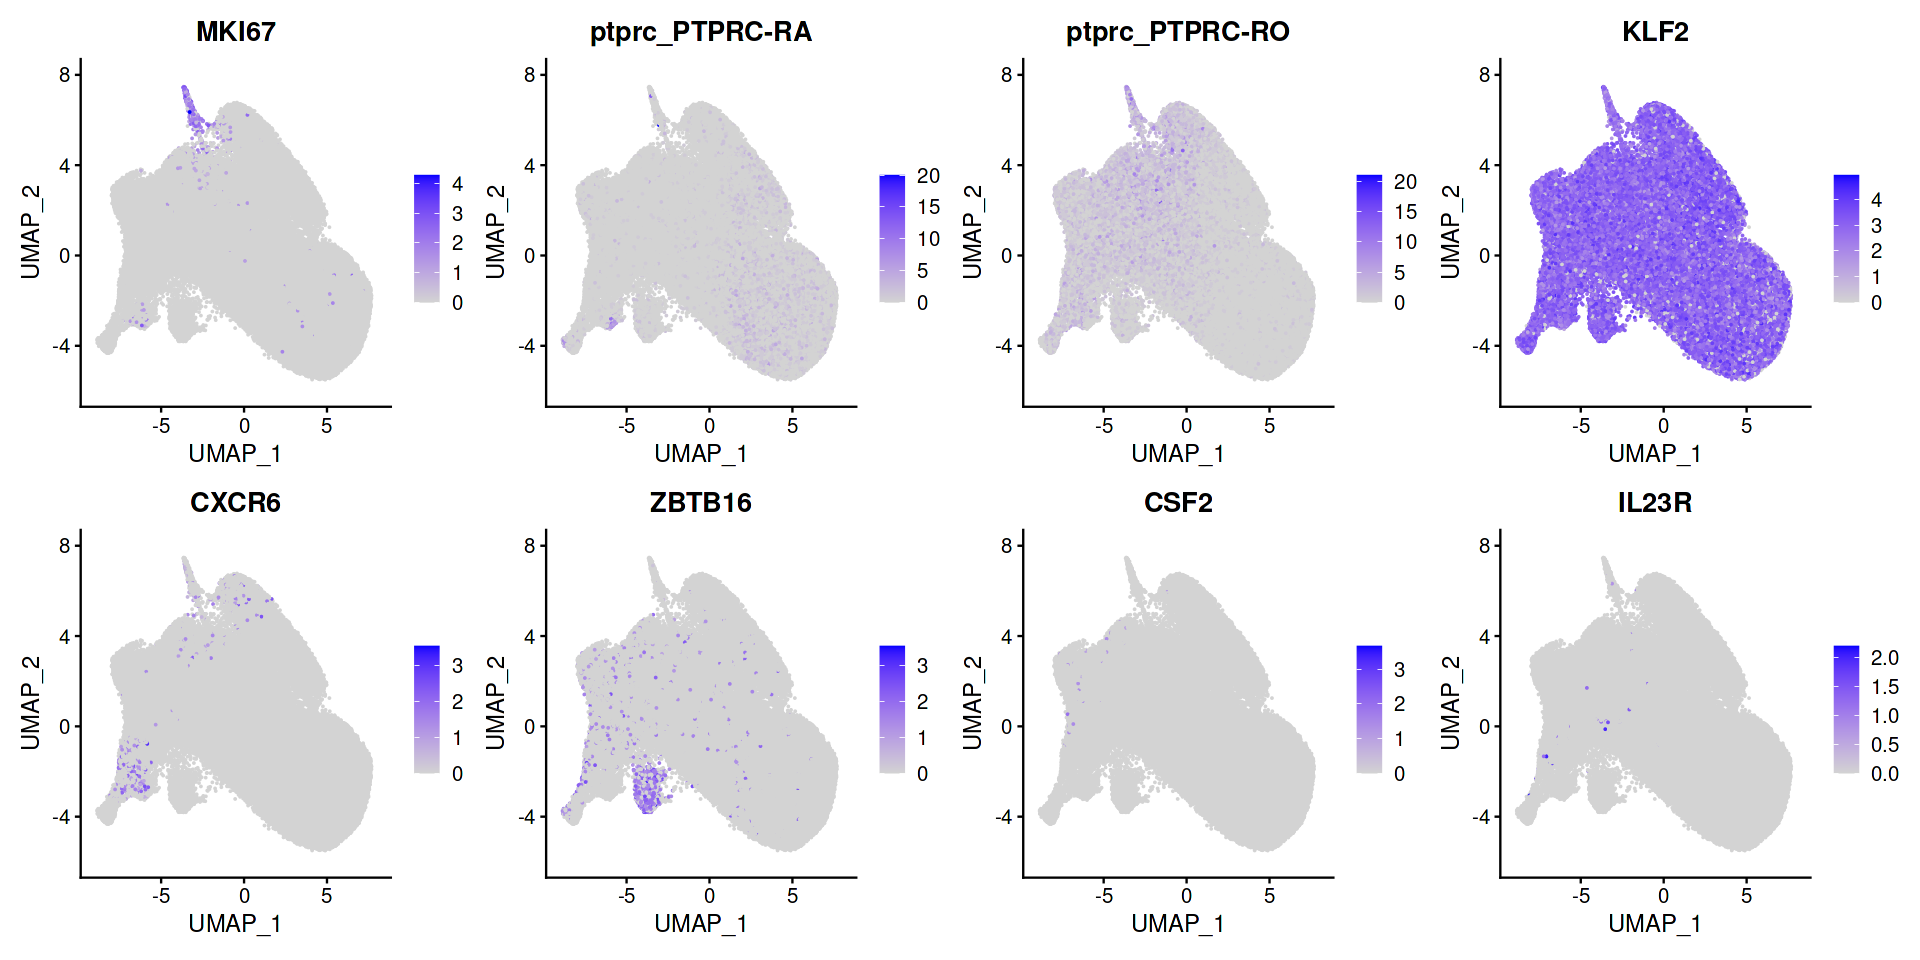

In [32]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd4, features = c("MKI67", "PTPRC-RA", "PTPRC-RO", "KLF2", "CXCR6", "ZBTB16", "CSF2", "IL23R"), ncol = 4)

In [33]:
new_dia_cd4@meta.data  %>% colnames

[1] "orig.ident"          "nCount_RNA"          "nFeature_RNA"       
 [4] "percent.mt"          "percent.rp"          "nCount_Antibodies"  
 [7] "nFeature_Antibodies" "hashtags"            "Experiment_ID"      
[10] "Prepared_by"         "Sample_ID"           "Well"               
[13] "Hashtag"             "Hashtag_sequence"    "Hashtag_cat_n"      
[16] "Hashtag_dilution"    "Project.code"        "Well_CT_ID"         
[19] "Condition"           "Disease"             "Time"               
[22] "Species"             "Age"                 "Age_group"          
[25] "Sex"                 "Library_code"        "Patient_ID"         
[28] "is_cell"             "chain"               "contig_id"          
[31] "high_confidence"     "productive"          "length"             
[34] "reads"               "umis"                "vdj_source"         
[37] "count_TRA"           "count_TRB"           "count_Multi"        
[40] "cdr3_A1"             "cdr3_A1_nt"          "cdr3_A2"            
[43] "cdr3_A2_nt"          "cdr3_B"              "cdr3_B_nt"          
[46] "cdr3_Multi"          "cdr3_Multi_nt"       "v_gene_A1"          
[49] "j_gene_A1"           "v_gene_A2"           "j_gene_A2"          
[52] "v_gene_B"            "d_gene_B"            "j_gene_B"           
[55] "v_gene_Multi"        "d_gene_Multi"        "j_gene_Multi"       
[58] "clonotypes"          "has.VDJ"             "has.complete.VDJ"   
[61] "nCount_PTPRC"        "nFeature_PTPRC"      "RNA_snn_res.0.5"    
[64] "seurat_clusters"     "clonotype.repeated"  "RNA_snn_res.1"

In [34]:
new_dia_cd4$Experiment_ID  %>% table

.
Exp10 Exp11 Exp16 Exp18 Exp19 Exp20 
 6736  6552 14018 24328 19976 15238 

In [35]:
new_dia_cd4$Condition  %>% table

.
   Ctrl T0    Ctrl T1     Dia T0     Dia T1 Pre-Dia T0 
     16594       4122      37989      25671       2472 

In [36]:
new_dia_cd4@meta.data  <- new_dia_cd4@meta.data  %>% separate(Condition, into = c("Disease", "Time"), remove = F, sep = " ")

In [37]:
new_dia_cd4$Time  <- if_else(is.na(new_dia_cd4$Time), "T0", new_dia_cd4$Time)

In [38]:
new_dia_cd4$Sample_char  <- paste(new_dia_cd4$Patient_ID, 
                                  new_dia_cd4$Disease,
                                  new_dia_cd4$Time,
                                  new_dia_cd4$Age_group,
                                  new_dia_cd4$Sex,
                                  new_dia_cd4$Experiment_ID)

### PCA on samples

In [39]:
cd4_samples  <- AverageExpression(new_dia_cd4, group.by = "Sample_char", return.seurat = T)

Centering and scaling data matrix



In [40]:
cd4_samples  <- FindVariableFeatures(cd4_samples)

In [41]:
cd4_samples  <- RunPCA(cd4_samples)

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  PCBP2, ST13, RGS10, LSM5, ALKBH7, CALM3, EEF1D, SMPD1, EEF1A1, CCNI 
	   UQCRB, APEX1, LDLRAP1, CD7, C11orf1, TMIGD2, MMP28, GRINA, NOP53, LITAF 
	   SNRPN, SARAF, ATP6V0E2, METTL21A, AIF1, SCML4, HEBP1, TSPAN3, C12orf57, FBL 
Negative:  ZNRF2, TGFB1, GNB1, CDV3, STK24, GNAS, GNAI2, CD81, KMT2A, FAM117A 
	   MALT1, ABHD17A, URI1, PIP4K2A, GRK2, HNRNPD, PLCL2, TAF10, GLS, SRRM2 
	   OSBP, MAZ, CLPTM1L, KIAA2013, CSNK2A2, TMEM238, KCMF1, CAPNS1, CCNY, EIF3A 
PC_ 2 
Positive:  MTRNR2L12, WDR83OS, DNAJC25-GNG10, DERPC, WASH6P, AMMECR1L, RFLNB, AC007326.4, R3HDM2, COL6A3 
	   PMS2, USF2, PRRG3, ZBED6, RYBP, C17orf49, AL662899.2, RBFOX1, ENO3, GALNT1 
	   Z83844.2, ANTXRL, CRYBB2, PKD1, AL117339.4, FAM153B, STAG3, DPP6, MAP1LC3B2, MOB2 
Negative:  IL2RG, ARL6IP1, CRIP1, STXBP2, AC005833.1, SARNP, ECH1, NAA10, DYNLRB1, A

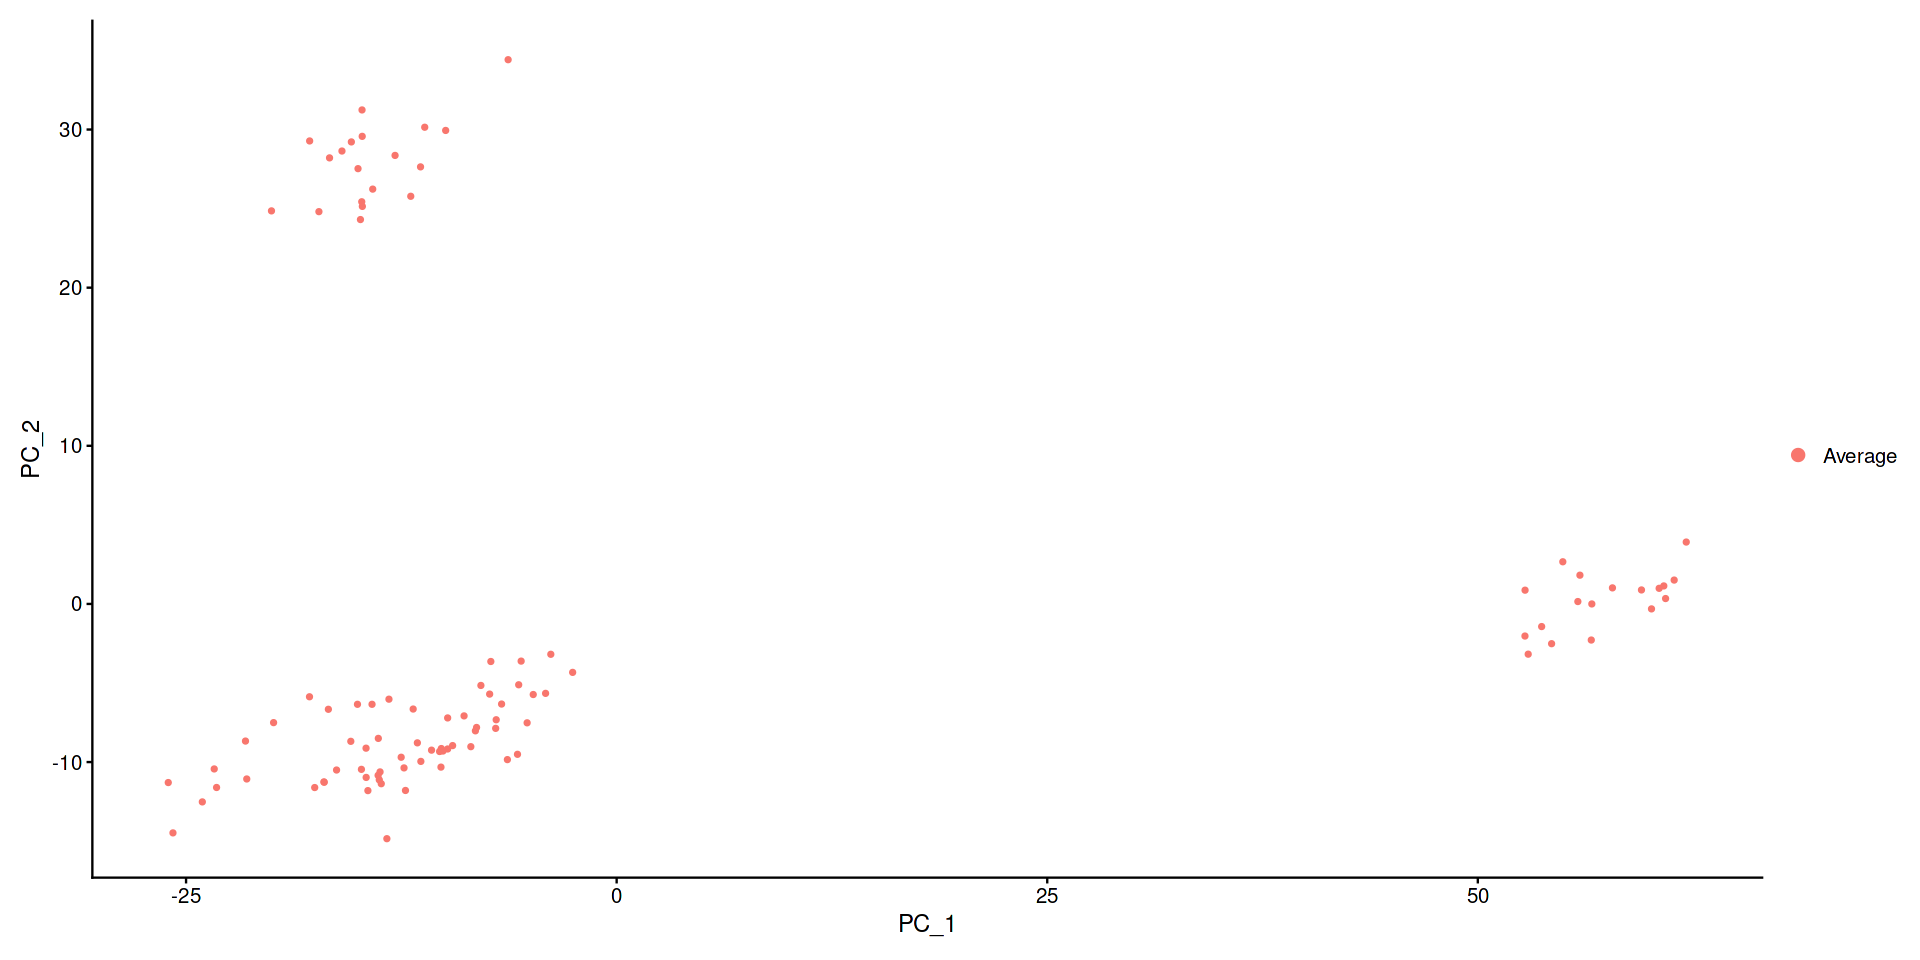

In [42]:
DimPlot(cd4_samples)

In [43]:
cd4_samples$Sample_char  <- colnames(cd4_samples)

In [44]:
cd4_samples$Sample_char  %>% table

.
    101 Dia T0 1 M Exp18     101 Dia T1 1 M Exp18     102 Dia T0 1 M Exp18 
                       1                        1                        1 
    102 Dia T1 1 M Exp18     103 Dia T0 2 M Exp18     103 Dia T1 2 M Exp18 
                       1                        1                        1 
    104 Dia T0 3 M Exp10     104 Dia T0 3 M Exp18     104 Dia T1 3 M Exp18 
                       1                        1                        1 
    105 Dia T0 1 M Exp10     105 Dia T0 1 M Exp18     105 Dia T1 1 M Exp18 
                       1                        1                        1 
    106 Dia T0 1 F Exp10     106 Dia T0 1 F Exp18     106 Dia T1 1 F Exp18 
                       1                        1                        1 
    107 Dia T0 1 M Exp11     107 Dia T0 1 M Exp18     107 Dia T1 1 M Exp18 
                       1                        1                        1 
    108 Dia T0 2 F Exp10     108 Dia T0 2 F Exp18     108 Dia T1 2 F Exp18 
          

In [45]:
cd4_samples@meta.data  <- cd4_samples@meta.data  %>% separate(Sample_char, 
                                                              into = c("Patient_ID",
                                                                      "Disease",
                                                                      "Time",
                                                                      "Age_group",
                                                                      "Sex",
                                                                      "Exp"), 
                                                             sep = " ",
                                                             remove = F)

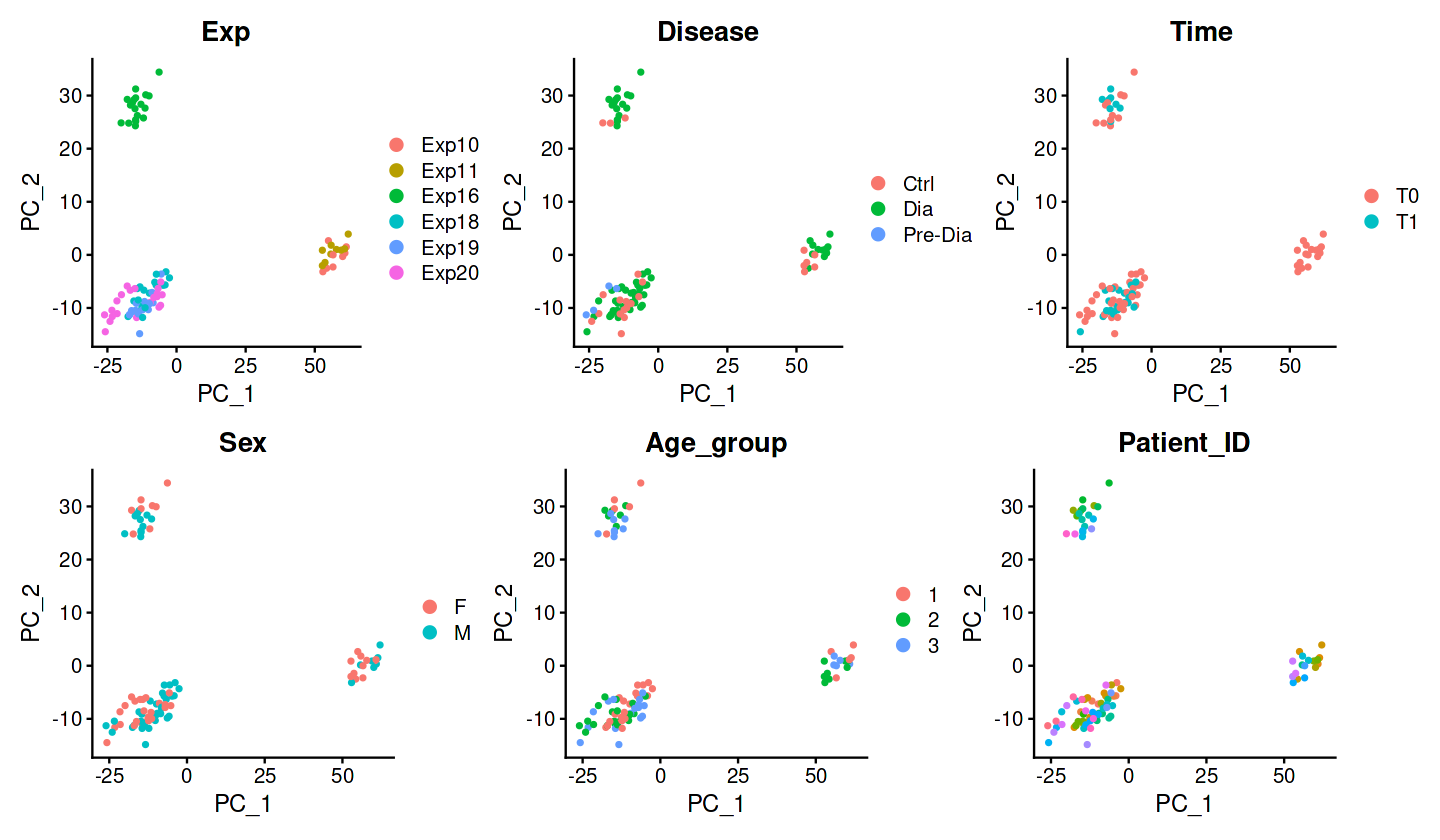

In [46]:
options(repr.plot.width = 12, repr.plot.height = 7)
(DimPlot(cd4_samples, group.by = "Exp") + DimPlot(cd4_samples, group.by = "Disease") + DimPlot(cd4_samples, group.by = "Time")) / (DimPlot(cd4_samples, group.by = "Sex") + DimPlot(cd4_samples, group.by = "Age_group") + (DimPlot(cd4_samples, group.by = "Patient_ID") + NoLegend()))

## STACAS Integration over Experiment

In [47]:
merged.list  <- SplitObject(new_dia_cd4, split.by = "Experiment_ID")

In [48]:
plan("sequential")

In [49]:
# normalize and identify variable features for each dataset independently
merged.list <- lapply(X = merged.list, FUN = function(x) {
    DefaultAssay(x)  <- "RNA"
    x$barcode  <- colnames(x)
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

library(STACAS)

new_dia_experiment <- Run.STACAS(merged.list, dims = 1:12)
new_dia_experiment <- RunUMAP(new_dia_experiment, dims = 1:12) 

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.0 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Preparing PCA embeddings for objects...

Building integration tree with base dataset: 4

Merging dataset 3 into 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 5 into 4 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 6 into 4 3 5

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding 

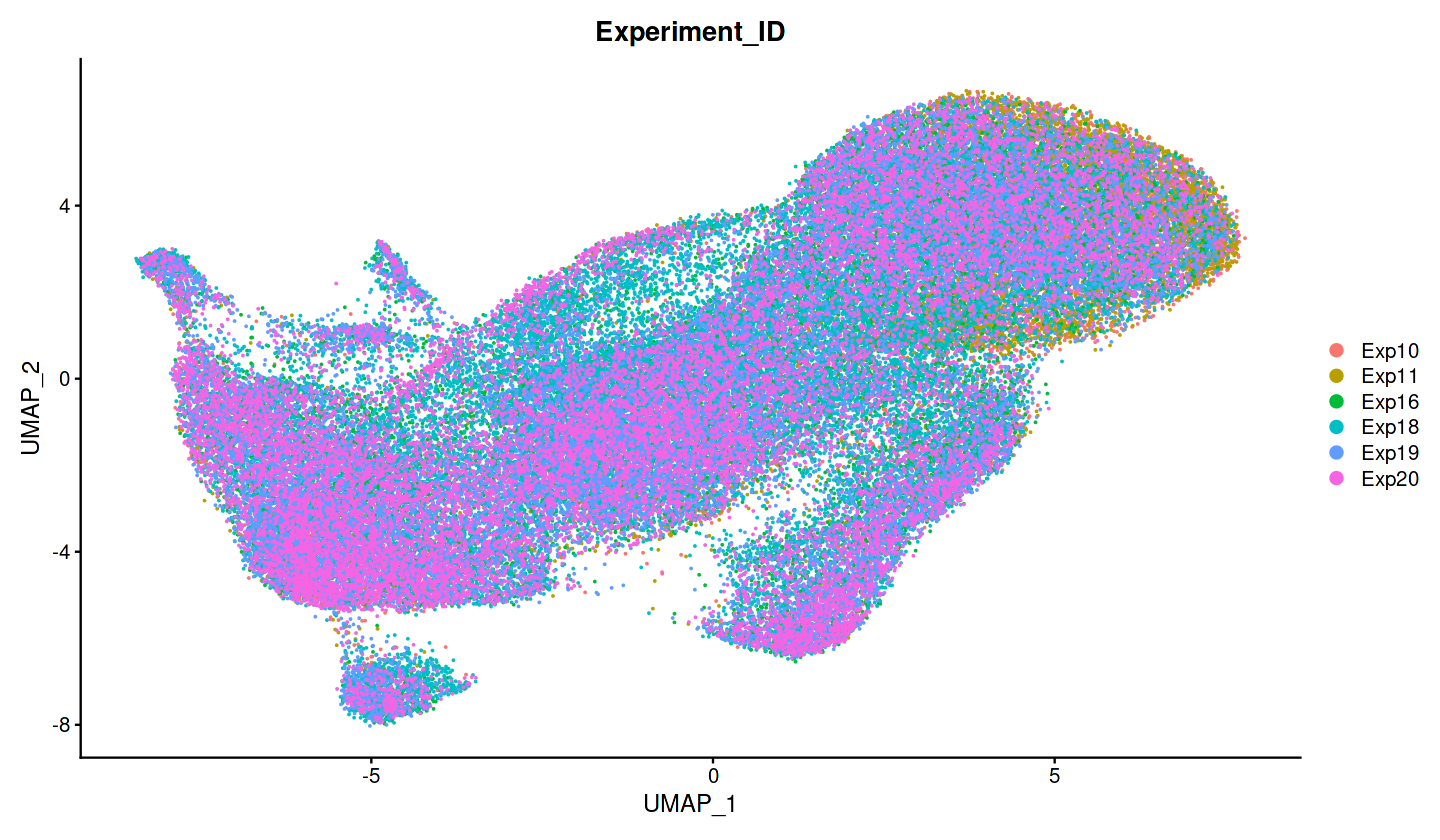

In [50]:
# Visualize

DimPlot(new_dia_experiment, group.by = c("Experiment_ID"))

In [51]:
saveRDS(new_dia_experiment, "data/processed/cd4_full.rds")

# Add metadata

In [69]:
md_dia  <- read_xlsx("data/dia_metadata.xlsx")

In [70]:
md_dia

id_pat patient rc         dat_nar    matched_dataset_manual
1  101    101     1812230552 2018-12-23 NA                    
2  102    102     1711110951 2017-11-11 NA                    
3  103    103     1304191240 2013-04-19 yes                   
4  104    104     0408165087 2004-08-16 NA                    
5  105    105     1706101309 2017-06-10 NA                    
6  106    106     1959271281 2019-09-27 NA                    
7  107    107     1610250708 2016-10-25 NA                    
8  108    108     1355270697 2013-05-27 yes                   
9  109    109     1506260129 2015-06-26 NA                    
10 110    110     1110211542 2011-10-21 NA                    
11 111    111     1053144928 2010-03-14 NA                    
12 112    112     1052214955 2010-02-21 NA                    
13 113    113     1308130153 2013-08-13 NA                    
14 114    114     1555051839 2015-05-05 NA                    
15 115    115     1205110896 2012-05-11 yes                   
16 116    116     1803170534 2018-03-17 NA                    
17 117    117     1651170972 2016-01-17 NA                    
18 118    118     1006214715 2010-06-21 NA                    
19 119    119     1660071611 2016-10-07 NA                    
20 120    120     1203604039 2012-03-10 NA                    
21 121    121     0704242715 2007-04-24 NA                    
22 122    122     0507194468 2005-07-19 NA                    
23 123    123     0412304453 2004-12-30 NA                    
24 124    124     1201161731 2012-01-16 NA                    
25 125    125     0507144693 2005-07-14 NA                    
26 126    126     0756094636 2007-06-09 yes                   
27 127    127     0561282095 2005-11-28 NA                    
28 128    128     0405268908 2004-05-26 NA                    
29 129    129     0510252094 2005-10-25 NA                    
30 130    130     0858067848 2008-08-06 NA                    
⋮  ⋮      ⋮       ⋮          ⋮          ⋮                     
48 101    101     1812230552 2018-12-23 NA                    
49 102    102     1711110951 2017-11-11 NA                    
50 103    103     1304191240 2013-04-19 yes                   
51 104    104     0408165087 2004-08-16 NA                    
52 105    105     1706101309 2017-06-10 NA                    
53 106    106     1959271281 2019-09-27 NA                    
54 107    107     1610250708 2016-10-25 NA                    
55 108    108     1355270697 2013-05-27 yes                   
56 109    109     1506260129 2015-06-26 NA                    
57 110    110     1110211542 2011-10-21 NA                    
58 111    111     1053144928 2010-03-14 NA                    
59 112    112     1052214955 2010-02-21 NA                    
60 113    113     1308130153 2013-08-13 NA                    
61 114    114     1555051839 2015-05-05 NA                    
62 115    115     1205110896 2012-05-11 yes                   
63 116    116     1803170534 2018-03-17 NA                    
64 117    117     1651170972 2016-01-17 NA                    
65 118    118     1006214715 2010-06-21 NA                    
66 119    119     1660071611 2016-10-07 NA                    
67 120    120     1203604039 2012-03-10 NA                    
68 121    121     0704242715 2007-04-24 NA                    
69 122    122     0507194468 2005-07-19 NA                    
70 123    123     0412304453 2004-12-30 NA                    
71 124    124     1201161731 2012-01-16 NA                    
72 125    125     0507144693 2005-07-14 NA                    
73 126    126     0756094636 2007-06-09 yes                   
74 127    127     0561282095 2005-11-28 NA                    
75 128    128     0405268908 2004-05-26 NA                    
76 129    129     0510252094 2005-10-25 NA                    
77 130    130     0858067848 2008-08-06 NA                    
   matched_group_manual matched_dataset_propensity matched_group_propensity
1  NA                

In [71]:
md_seurat  <- new_dia_experiment@meta.data

In [72]:
md_seurat$Patient_Time  <- paste(md_seurat$Patient_ID, md_seurat$Time)

In [73]:
md_joined  <- left_join(md_seurat, md_dia)

Joining with `by = join_by(Patient_Time)`


In [74]:
new_dia_experiment@meta.data  <- md_joined
rownames(new_dia_experiment@meta.data)  <- colnames(new_dia_experiment)

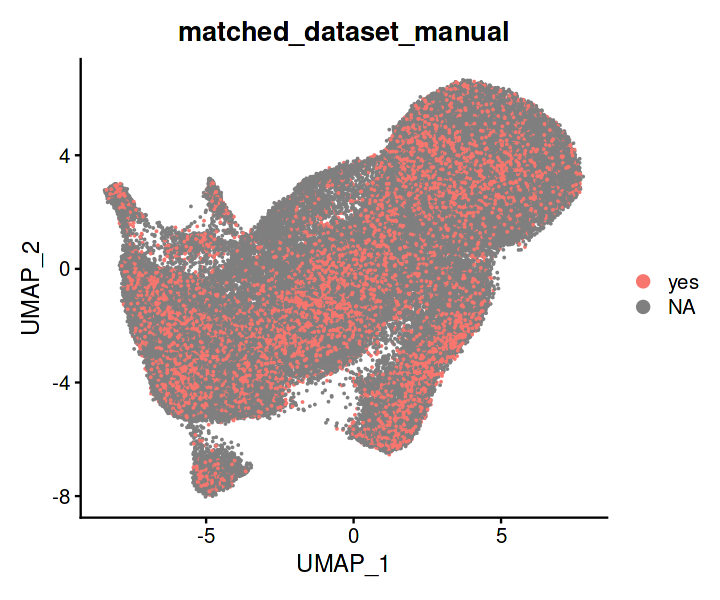

In [75]:
options(repr.plot.width = 6, repr.plot.height = 5)

DimPlot(new_dia_experiment, group.by = "matched_dataset_manual")

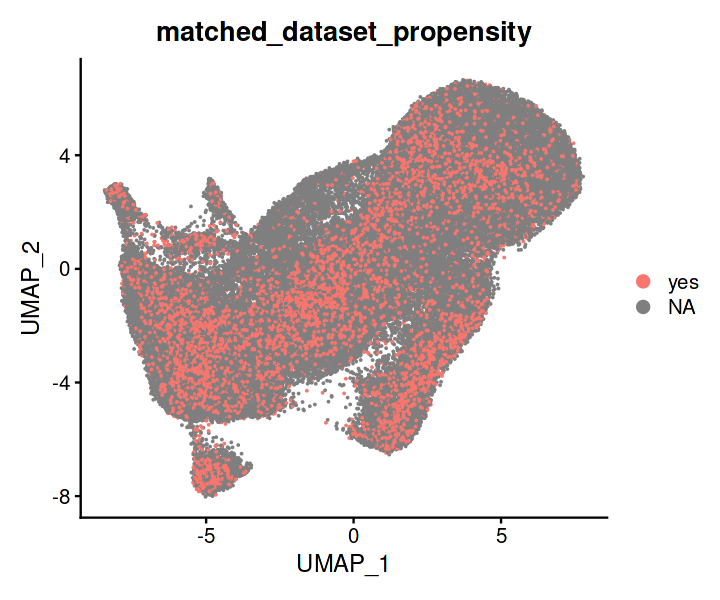

In [76]:
DimPlot(new_dia_experiment, group.by = "matched_dataset_propensity")

# Analysis CD4 Level 1

In [77]:
new_dia_cd4  <- new_dia_experiment

In [78]:
new_dia_cd4 <- FindNeighbors(new_dia_cd4, dims = 1:12)

Computing nearest neighbor graph

Computing SNN



In [79]:
new_dia_cd4 <- FindClusters(new_dia_cd4, resolution = 0.7)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86848
Number of edges: 2258487

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8384
Number of communities: 13
Elapsed time: 52 seconds


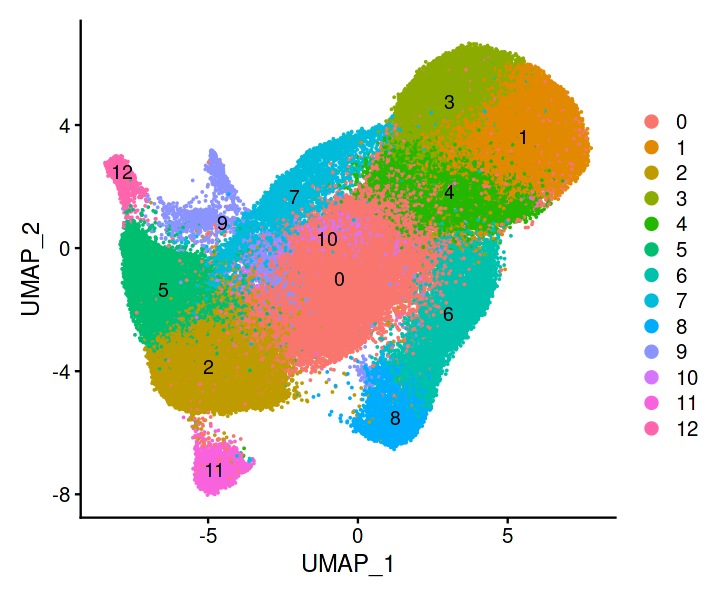

In [80]:
DimPlot(new_dia_cd4, label = T)

In [81]:
new_dia_cd4@meta.data  <- new_dia_cd4@meta.data  %>% 
mutate(annotations_l1 = recode_factor(seurat_clusters, 
                                      "0" = "CD4 T cells",
                                     "1" = "CD4 T cells",
                                     "2" = "CD4 T cells",
                                     "3" = "CD4 T cells",
                                     "4" = "CD4 T cells",
                                     "5" = "CD4 T cells",
                                     "6" = "CD4 T cells",
                                     "7" = "CD4 T cells",
                                     "8" = "CD4 T cells",
                                     "9" = "CD4 T cells",
                                     "10" = "CD4 T cells",
                                     "11" = "Unconventional T cells",
                                     "12" = "CD4 T cells"))

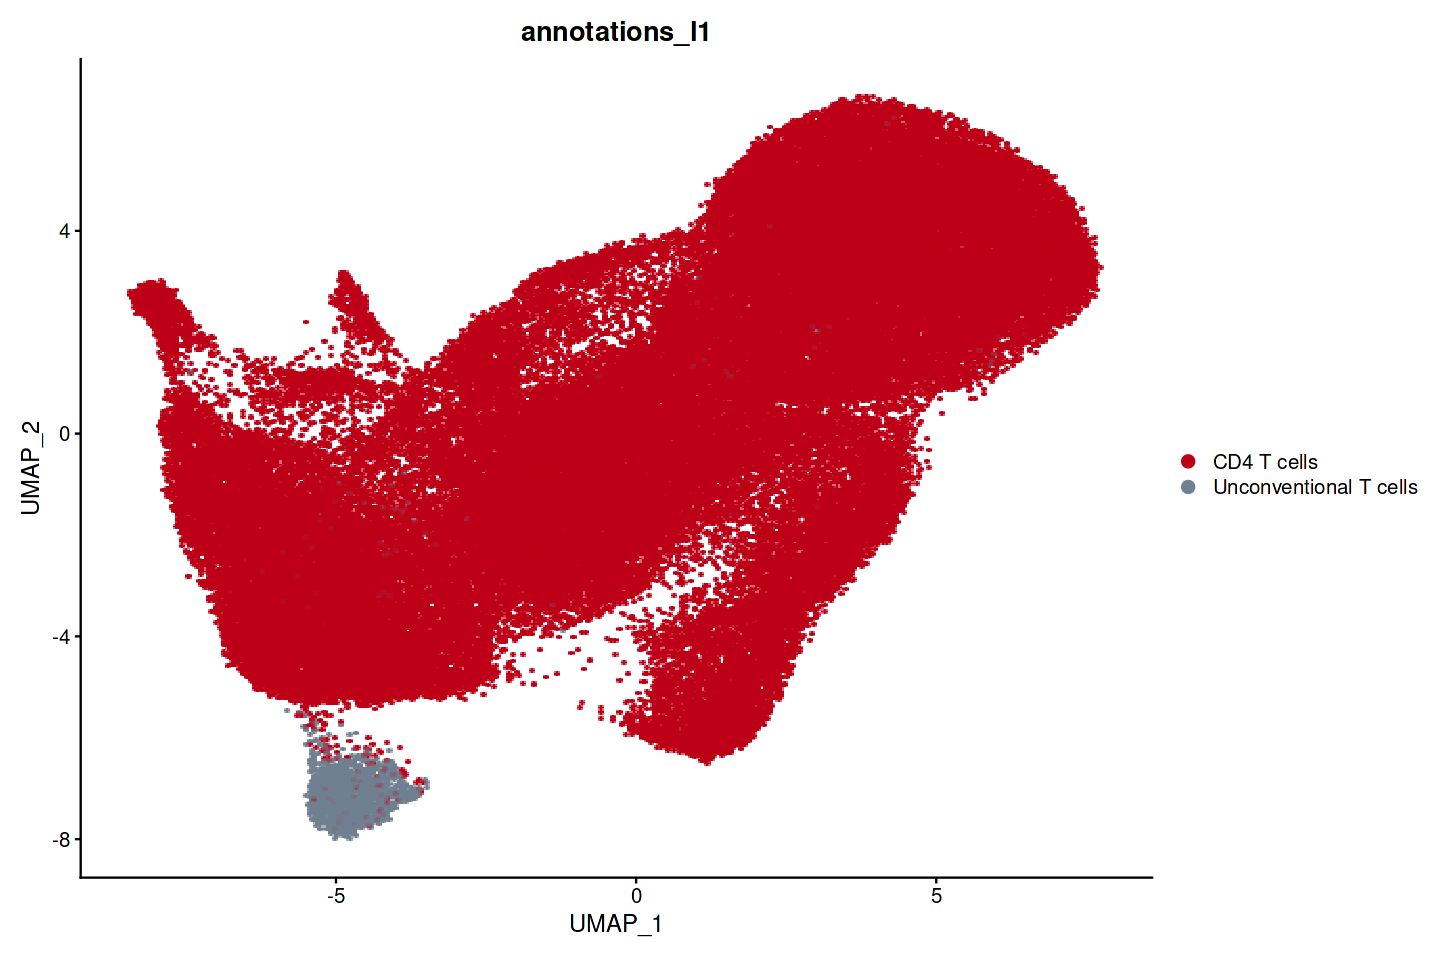

In [82]:
options(repr.plot.width = 12, repr.plot.height = 8)

DimPlot(new_dia_cd4, group.by = "annotations_l1", raster = T, pt.size = 2, 
       cols = c("#BD0017", "slategray"))

In [83]:
saveRDS(new_dia_cd4, "data/processed/cd4_full.rds")

# Analysis CD4 Level 2

In [85]:
merged.list  <- SplitObject(subset(new_dia_cd4, annotations_l1 == "CD4 T cells"), split.by = "Experiment_ID")

In [ ]:
new_dia_experiment <- Run.STACAS(merged.list, dims = 1:12)
new_dia_experiment <- RunUMAP(new_dia_experiment, dims = 1:12)

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”
Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”
Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in

In [ ]:
cd4_subcluster  <- new_dia_experiment

In [ ]:
cd4_subcluster <- FindNeighbors(cd4_subcluster, reduction = "pca", dims = 1:12)

In [ ]:
cd4_subcluster <- FindClusters(cd4_subcluster, resolution = 0.7)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)

DimPlot(cd4_subcluster, label = T)

In [808]:
cd4_subcluster@meta.data  <- cd4_subcluster@meta.data  %>% 
mutate(annotations_l2 = recode_factor(seurat_clusters, "0" = "Tfh",
                                     "1" = "Teff",
                                     "2" = "Naive",
                                     "3" = "Naive",
                                     "4" = "Naive",
                                     "5" = "Treg",
                                     "6" = "Teff",
                                     "7" = "Tfh",
                                     "8" = "ISAGhi",
                                     "9" = "Treg",
                                     "10" = "Proliferating",
                                     "11" = "Temra",
                                     "12" = "Teff"))